<a href="https://colab.research.google.com/github/anikch/paddy/blob/main/paddy_doctor_1_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.0 MB/s 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
!nvidia-smi

Mon Jul 11 09:30:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
train_table=pd.read_csv("/content/drive/MyDrive/thesis/dataset/paddy_doctor/train.csv")
train_table

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45
...,...,...,...,...
10402,107607.jpg,tungro,Zonal,55
10403,107811.jpg,tungro,Zonal,55
10404,108547.jpg,tungro,Zonal,55
10405,110245.jpg,tungro,Zonal,55


In [4]:
labels=list(np.unique(train_table['label']))
labels

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [5]:
train_data= tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/thesis/dataset/paddy_doctor/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='training',
                                                        batch_size= 128,
                                                        seed= 101)

val_data= tf.keras.utils.image_dataset_from_directory("/content/drive/MyDrive/thesis/dataset/paddy_doctor/train_images/",
                                                        labels='inferred',
                                                        label_mode='categorical',
                                                        class_names=labels,
                                                        color_mode='rgb',
                                                        image_size=(224,224),
                                                        shuffle=True,
                                                        validation_split=0.2,
                                                        subset='validation',
                                                        batch_size=128,
                                                        seed= 101)

Found 10407 files belonging to 10 classes.
Using 8326 files for training.
Found 10407 files belonging to 10 classes.
Using 2081 files for validation.


In [6]:
# Creating data augmentation layer

augmentation_layer= keras.Sequential([
    layers.RandomFlip("horizontal", seed= 101),
    layers.RandomZoom(0.2, seed= 101),
    layers.RandomRotation(0.2, seed= 101)
])

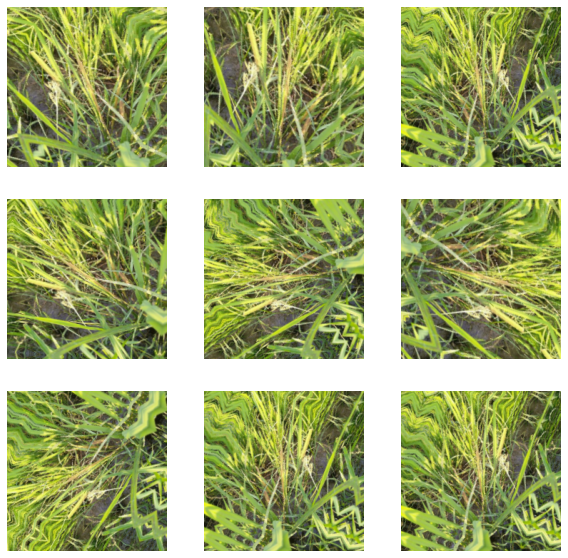

In [7]:
# Checking augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
  for i in range(9):
    augmented_images = augmentation_layer(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [8]:
augmented_train_data= train_data.map(
  lambda x, y: (augmentation_layer(x, training=True), y))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_data= augmented_train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data= val_data.cache().prefetch(buffer_size=AUTOTUNE)

# Fine Tune BiT Model

In [10]:
MODULE_URL = "https://tfhub.dev/google/bit/m-r101x3/1"

BATCH_SIZE = 128
SZ = 224
NUM_EPOCHS = 100
#steps_per_epoch= 9367//BATCH_SIZE
#validation_steps= 1040//BATCH_SIZE
#AUTO = tf.data.AUTOTUNE
NB_CLASSES = 10

In [11]:
hub_module = hub.KerasLayer(MODULE_URL)

model = keras.Sequential(
    [
        keras.Input((SZ, SZ, 3)),
        keras.layers.Rescaling(scale=1.0 / 255),
        hub_module,
        keras.layers.Dense(1024, activation = 'relu', kernel_regularizer='l2', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation = 'relu', kernel_regularizer='l2', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1128, activation = 'relu', kernel_regularizer='l2', kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(NB_CLASSES, kernel_initializer="zeros")
    ],
    name="bit_teacher_paddy_doctor",
)
print(f"Number of parameters (millions): {model.count_params() / 1e6}.")

Number of parameters (millions): 389.207778.


In [ ]:
SCHEDULE_LENGTH = 500
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

SCHEDULE_BOUNDARIES = [200, 300, 400]
lr = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES, values=[lr, lr * 0.1, lr * 0.001, lr * 0.0001]
)
optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

In [ ]:
tf.__version__

'2.8.2'

In [12]:
# Fine Tuning BiT model with Adam optimizer for 100 epochs

loss_fn = keras.losses.CategoricalCrossentropy(from_logits= True)
model.compile(optimizer= 'adam', loss=loss_fn, metrics=["accuracy",  tfa.metrics.F1Score(average='macro', num_classes= 10)])

history= model.fit(augmented_train_data, epochs=NUM_EPOCHS, validation_data=val_data)

Epoch 1/100
66/66 [==============================] - 204s 3s/step - loss: 20.5794 - accuracy: 0.6124 - f1_score: 0.5395 - val_loss: 7.8713 - val_accuracy: 0.4858 - val_f1_score: 0.4043
Epoch 2/100
66/66 [==============================] - 133s 2s/step - loss: 4.8356 - accuracy: 0.7037 - f1_score: 0.6541 - val_loss: 3.5780 - val_accuracy: 0.5526 - val_f1_score: 0.5088
Epoch 3/100
66/66 [==============================] - 133s 2s/step - loss: 2.5399 - accuracy: 0.7229 - f1_score: 0.6793 - val_loss: 2.4580 - val_accuracy: 0.6127 - val_f1_score: 0.4839
Epoch 4/100
66/66 [==============================] - 133s 2s/step - loss: 1.9580 - accuracy: 0.7374 - f1_score: 0.6947 - val_loss: 2.3675 - val_accuracy: 0.5632 - val_f1_score: 0.4917
Epoch 5/100
66/66 [==============================] - 133s 2s/step - loss: 1.7846 - accuracy: 0.7401 - f1_score: 0.6980 - val_loss: 2.1001 - val_accuracy: 0.6045 - val_f1_score: 0.5426
Epoch 6/100
66/66 [==============================] - 133s 2s/step - loss: 1.706

In [13]:
model.save("/content/drive/MyDrive/thesis/dataset/paddy_doctor/bit_teacher_paddy_doctor1_final")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/thesis/dataset/paddy_doctor/bit_teacher_paddy_doctor1_final/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/thesis/dataset/paddy_doctor/bit_teacher_paddy_doctor1_final/assets


In [ ]:
'''
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])
callback2=tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
history_tuned=model.fit(train_data, validation_data=val_data, epochs=40, initial_epoch=history.epoch[-1], callbacks=[callback2] )

# DeiT Model

In [14]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 20
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 10

In [15]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [16]:
def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [17]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

In [18]:
class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        # Add positional embeddings to the projected patches.
        encoded_patches = (
            self.positional_embedding + projected_patches
        )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled
            # mode.
            return x, x_dist

In [19]:
deit_tiny_distilled = ViTDistilled()

dummy_inputs = tf.ones((2, 224, 224, 3))
outputs = deit_tiny_distilled(dummy_inputs, training=False)
print(outputs.shape)

(2, 10)


In [20]:
class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Forward pass of teacher
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)

        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

In [21]:
bit_teacher_paddy_doc = keras.models.load_model("/content/drive/MyDrive/thesis/dataset/paddy_doctor/bit_teacher_paddy_doctor1_final")

In [22]:
NUM_EPOCHS= 100

In [23]:
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher= bit_teacher_paddy_doc)

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy", tfa.metrics.F1Score(average='macro', num_classes= 10)],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
history1 = deit_distiller.fit(augmented_train_data, validation_data=val_data, epochs=NUM_EPOCHS)

Epoch 1/100
66/66 [==============================] - 151s 2s/step - accuracy: 0.1632 - f1_score: 0.0673 - student_loss: 2.3173 - distillation_loss: 2.2442 - val_accuracy: 0.1408 - val_f1_score: 0.0247 - val_student_loss: 2.2148 - val_distillation_loss: 0.0000e+00
Epoch 2/100
66/66 [==============================] - 128s 2s/step - accuracy: 0.1724 - f1_score: 0.0577 - student_loss: 2.1973 - distillation_loss: 2.1494 - val_accuracy: 0.1408 - val_f1_score: 0.0247 - val_student_loss: 2.2137 - val_distillation_loss: 0.0000e+00
Epoch 3/100
66/66 [==============================] - 128s 2s/step - accuracy: 0.1786 - f1_score: 0.0641 - student_loss: 2.1929 - distillation_loss: 2.1404 - val_accuracy: 0.1879 - val_f1_score: 0.0608 - val_student_loss: 2.1960 - val_distillation_loss: 0.0000e+00
Epoch 4/100
66/66 [==============================] - 129s 2s/step - accuracy: 0.2186 - f1_score: 0.1039 - student_loss: 2.1566 - distillation_loss: 2.0860 - val_accuracy: 0.2210 - val_f1_score: 0.1161 - val_s

In [24]:
!nvidia-smi

Mon Jul 11 17:36:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    42W / 300W |  15503MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

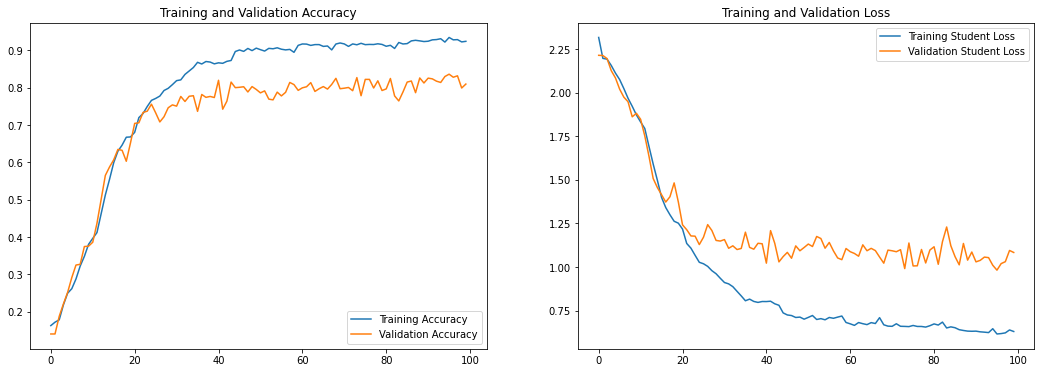

In [28]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['student_loss']
val_loss = history1.history['val_student_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Student Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Student Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
import json
with open('/content/drive/MyDrive/thesis/dataset/paddy_doctor/bit_teacher_paddy_doctor1_final/DeiT/history1.json', 'w') as f:
    json.dump(history1.history, f)

In [46]:
print(f"Number of parameters (millions): {deit_tiny.count_params() / 1e6}.")

Number of parameters (millions): 9.081428.
